# Project 2
## Lending Club Classification
Our goal for the Lending Club classification exercise is to create a model that determines whether or not a loanee will default.  

A loan enters default status once it is overdue by 120 days.  For the purpose of our classification exercise we will assume loans in a late status will convert into a default status.  This assumption also increases the population size of our data that will be used for model training. As such, we will assume the following statuses are 'default'
* Late (16 - 30 days)
* Late (31 - 120 days)
* Default
* Charged Off

We will define model success by looking at a model's ROC AUC score.  This will allow us to measure how well our model predicts default loans, taking into account true positives & false positives. 

In [17]:
# Import all our varaibles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
sns.set(style='whitegrid', color_codes=True)

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import ExtraTreesClassifier

# scores
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# hide divide by 0/null warnings
import numpy as np
np.seterr(divide='ignore', invalid='ignore')

# hide user warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

We first import our pre-processed data.  We've identified several category columns and will ensure these are set with the appropriate datatype before moving forward. 

In [18]:
#define category columns
cat_cols = ['grade', 
            'sub_grade',
            'home_ownership',
            'verification_status',
            'loan_status',
            'purpose',
            'addr_state',
            'initial_list_status',
            'application_type',
            'hardship_flag'
           ]

# import data
df_raw = pd.read_csv('../data/processed/LCData_processed.csv', index_col=0)

# convert category columns
for c in cat_cols:
    df_raw[c] = pd.Categorical(df_raw[c])

Our goal is to build a model based on completed loans - meaning loans that have been fully repaid or defaulted.  We will filter our dataset to remove any currently outstanding loans.

In [19]:
completed_loan_status = ['Fully Paid', 
                         'Charged Off', 
                         'Default',
                         'Late (16-30 days)',
                         'Late (31-120 days)'
                        ]

# filter our loan data
df = df_raw[df_raw.loan_status.str.contains('|'.join(completed_loan_status))]

## Logistic Regression - Feature Engineered Columns
As a starting point, we will build a model using only our engineered columns.  Our engineered columns are as follows:

In [20]:
feat_eng_cols = ['low_deliquent_job',
                 'credit_line_length_mnths',
                 'inq_last_6mths_cat',
                 'pub_rec_cat',
                 'fully_funded',
                 'issue_d_month', 
                 'issue_d_year'
                 ]

With our columns defined, we can create a simple logistic regression to see how well our data performs.

In [21]:
# create our X and y datasets
X = df[feat_eng_cols]
y = df.is_bad

# create the dummies for our category columns
X = pd.get_dummies(X)

# split our data.  Here we use the stratify option to ensure our split datasets contain the same distribution between
# majority & minority class
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# scale the data
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)

# fit the classifier
clf = LogisticRegression()
clf.fit(X_train_scaled, y_train)

# predict using the training dataset
y_pred = clf.predict(X_train_scaled)

# find the prediction precentage for the 'default' class (which is the second column)
y_score = clf.predict_proba(X_train_scaled)[:,1]

# find the scores
accuracy = clf.score(X_train_scaled, y_train)
roc_auc = roc_auc_score(y_train, y_score)

# print scores
print('Accuracy: {}'.format(accuracy))
print('ROC AUC: {}'.format(roc_auc))

Accuracy: 0.8074194962474714
ROC AUC: 0.5659423551308429


The accuracy score states that we are ~81%.  One would assume this is great.  Looking at the ROC AUC score, we find out that the accuracy score is not good at all. 

A roc auc score of ~57% is slightly better than randomly guessing the outcome.  I believe we see this bad score due to unbalanced classes.  Let's take a look at the confusion matrix and classification report.

In [22]:
print(confusion_matrix(y_train, y_pred))

[[152876      0]
 [ 36463      0]]


In [23]:
print(classification_report(y_train, y_pred, target_names=['0', '1']))

             precision    recall  f1-score   support

          0       0.81      1.00      0.89    152876
          1       0.00      0.00      0.00     36463

avg / total       0.65      0.81      0.72    189339



The results look even worse now.  We predict 'non-default' for everything.  At the moment, our model is not able to predict when a loanee will default.  It could be due to class imbalance.  

Let's try balancing our classes and re-running the model.

### SMOTE  Class Balancing
Using SMOTE, we are able to bring balance to our minority class, which will hopefully improve our accuracy score. 

In [24]:
from imblearn.over_sampling import SMOTE
from collections import Counter

X = pd.get_dummies(df[feat_eng_cols])
y = df.is_bad

# balance our class
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_sample(X, y)

# display the sampled classes
print('Resampled dataset shape {}'.format(Counter(y_res)))

Resampled dataset shape Counter({0: 203835, 1: 203835})


We now have balanced classes and are ready to perform a logisitc regression to see how well our model predicts the outcome.

In [25]:
# split our data
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_res, y_res, test_size=0.25, random_state=42)

# scale the data
sc = StandardScaler()
X_train_scaled_bal = sc.fit_transform(X_train_bal)
X_test_scaled_bal = sc.transform(X_test_bal)

# fit the classifier
clf = LogisticRegression()
clf.fit(X_train_scaled_bal, y_train_bal)

# predict using the training dataset
y_pred_fe = clf.predict(X_train_scaled_bal)

# find the prediction precentage for the 'default' class (which is the second column)
y_score_fe = clf.predict_proba(X_train_scaled_bal)[:,1]

# find the scores
accuracy_bal = clf.score(X_train_scaled_bal, y_train_bal)
mse_bal = mean_squared_error(y_train_bal, y_pred_fe)
roc_auc_bal = roc_auc_score(y_train_bal, y_score_fe)

# print scores
print('Accuracy: {}'.format(accuracy_bal))
print('ROC AUC: {}'.format(roc_auc_bal))


Accuracy: 0.5504559250634501
ROC AUC: 0.5619283740232979


The ROC AUC score appears to be the same as we saw in our initial tests, however we can see that the accuracy score mirrors our ROC AUC score.  This should mean that we are successfully predicting loan defaults now.  Let's look at our confusion matrix and classification report to confirm. 

In [26]:
confusion_matrix(y_train_bal, y_pred_fe)

array([[ 64397,  88376],
       [ 49073, 103906]])

In [27]:
print(classification_report(y_train_bal, y_pred_fe, target_names=['0', '1']))

             precision    recall  f1-score   support

          0       0.57      0.42      0.48    152773
          1       0.54      0.68      0.60    152979

avg / total       0.55      0.55      0.54    305752



Although the balanced class allows us to predict the default class, we still have a model that predicts just slight better than randomly guessing the outcome.  

This is most likley due to the few number of features used in the current model.  We can improve the model by adding additional features.

## Predicting based on the majority class
We've seen that our current model performs poorly.  If we were to create a model that always predicts the majority class, how well would our model perform? 

We already know that the majority class is 'non-default' (represented by the 0 class).  Let's calcluate the prediction accuracy of the majority class. 

In [28]:
# find the counts for majority and minority classes
majority = len(df[df.is_bad == 0])
minority = len(df[df.is_bad == 1])

# calculate the accuracy
print('Majority benchmark: {}'.format(majority / (majority + minority)))

Majority benchmark: 0.8074176183289563


If we were to always predict the majority class of 'non-default', we would be accurate about 81% of the time.  

Our current model is only accurate ~55% of the time.  Our goal should be to create a model that can predict better than 81% accuracy. 

## Predicting based on loan grade
We now know that we can achieve about 81% accuracy by simply predicting 'non-default' for every loan.  This doesn't provide a truly accurate model - but it provides us a benchmark.  

We can produce another benchmark by looking at predicting loan default by loan grades.  We will take a look at default rates per loan grades below: 

In [29]:
# Lets calculate the default rates for loans based on lending club's grades
for g in sorted(df.grade.unique()):
    
    #calculate default rate
    default_rate = df[(df.is_bad ==1) & (df.grade==g)].loan_amnt.count() / df[df.grade==g].loan_amnt.count() 

    print('{0}: {1:.3f}'.format(g, default_rate))

A: 0.062
B: 0.128
C: 0.210
D: 0.289
E: 0.360
F: 0.411
G: 0.438


As one would expect, loans of grade 'A' have less likelihood of defaulting when compared to loans of grade 'G'.  Using this approach, we assume that if a loan has a grade of 'A', it will default only 6% of the time.  Our current model will only predict the correct response about 55% of the time, no matter what the loan grade is set to.  We can use the loan grade predictions here for our future tests once we settle on a final model. 

## Logistic Regression - All Columns
We've investigated creating a model using only our engineered columns only to find that our model behaves poorly.  Our next step is to create a model using all features (columns).  

We have several features that relate directly to the status of a loan. These features need to be removed from our dataset prior to building our model.

Features will be removed from the dataset if they...
* are related to a lending club defined status (e.g. grade, sub_grade, loan_status)
* are related to the health status of a loan (e.g. current payments, interest collected, late fees etc) 

The features to be removed are as follows:

In [30]:
drop_cols = ['total_pymnt',
             'total_pymnt_inv',
             'total_rec_int',
             'total_rec_late_fee',
             'total_rec_prncp',
             'funded_amnt',
             'funded_amnt_inv',
             'out_prncp',
             'out_prncp_inv',
             'last_pymnt_amnt',
             'loan_status',
             'grade',
            'sub_grade']

In [31]:
# create a new dataset
df_sub = df.drop(drop_cols, axis=1)

# create our X & Y
X = pd.get_dummies(df_sub.drop('is_bad', axis=1))
y = df_sub.is_bad

# split our data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Now that we have a dataset, let's try performing a logisitic regression using all features.  Our prior model suffered from class imbalance due to the fact that we had so few features.  We will try the logistic regression without balancing the classes to see how we perform. 

In [32]:
# Build a pipeline
pipe_lr_af = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression())
    ])

# fit the data
pipe_lr_af.fit(X_train, y_train)

# predict X
y_pred_lr_af = pipe_lr_af.predict(X_train)

# find the assigned scores for the y predictions (which is the second column in predicitions)
y_score_lr_af = pipe_lr_af.predict_proba(X_train)[:,1]

# find the scores
accuracy_score = pipe_lr_af.score(X_train, y_train)
mse = mean_squared_error(y_train,y_pred_lr_af)
roc_auc = roc_auc_score(y_train, y_score_lr_af)

# print scores
print('Training Scores')
print('Accuracy: {}'.format(accuracy_score))
print('ROC AUC: {}'.format(roc_auc))

Training Scores
Accuracy: 0.9054341683435531
ROC AUC: 0.8759851049290165


In [33]:
#Let's have a look at the classification report
print(classification_report(y_train, y_pred_lr_af, target_names=['0', '1']))

             precision    recall  f1-score   support

          0       0.90      1.00      0.94    152880
          1       0.99      0.52      0.68     36459

avg / total       0.91      0.91      0.89    189339



Our scores look considerably better when using all features.  We are predicting the default class, which we saw was a problem when using few features for our model. Our recall score for the default class is not great. 

Let's validate our scores against our test dataset to verify that we can accurately predict defaults.

In [34]:
# predict X
y_pred_test = pipe_lr_af.predict(X_test)

# find the assigned scores for the y predictions (which is the second column in predicitions)
y_score_test = pipe_lr_af.predict_proba(X_test)[:,1]

# find the scores
accuracy_score = pipe_lr_af.score(X_test, y_test)
roc_auc = roc_auc_score(y_test, y_score_test)

# print scores
print('Testing Scores')
print('Accuracy: {}'.format(accuracy_score))
print('ROC AUC: {}'.format(roc_auc))

Testing Scores
Accuracy: 0.9052508159837754
ROC AUC: 0.8737729370665167


When looking at the test results, we find that the model ROC AUC score is algined with what we saw with our training dataset.  Let's validate this using cross validation:

In [35]:
# let's find the cross validation score
scores = cross_val_score(pipe_lr_af, X, y, scoring ='roc_auc', cv=10)
scores

array([ 0.90477956,  0.90679215,  0.91289208,  0.89250252,  0.89875116,
        0.8654038 ,  0.84693175,  0.83711605,  0.80597524,  0.74070669])

In [36]:
print("Accuracy: {0:.2f} (+/- {1:.5f})".format(scores.mean(), scores.std() * 2))

Accuracy: 0.86 (+/- 0.10471)


Perfect. We've improved our accuracy considerably.  We have a cross validatin ROC AUC score of 86%.  We can say that having more features allows us to predict outcomes much more accurately.  Our recall score for the 'default' class still is not great, but we will see if we can fine tune this later on in the notebook    

## Logistic Regression - Feature Selection
With a solid score using Logistic Regression, our next question is whether or not we can reduce the complexity of our model.  We can accomplish this by limiting the number of features required to predict the outcome.  

We will try 3 different feature selection methods
* SelectFromModel using LinearSVC & ExtraTreeClassifier
* PCA
* SelectKBest using f_classif

Once we identify the best selection method & threshold, we will perform a final scoring.  We will try multiple thresholds in our SelectFromModel to find a balance between features and scoring. 

In [37]:
# define our classifiers
clf_lsvc = LinearSVC(penalty='l1', dual=False, random_state=42)
clf_etc = ExtraTreesClassifier(random_state=42)

# create our parameters for testing
feat_selectors = [clf_lsvc, clf_etc]
feat_selector_names = ['LinearSVC', 'ExtraTreesClassifier']
thresholds = [0.00001, 0.0001, 0.01, 0.02, 0.03, 0.04, 'mean']

# create a place to store our results
results_fs=[]
column_names = ['feat_selector', 'threshold', 'accuracy', 'rmse', 'roc_auc', 'features_selected']

# loop through each feat selector
for i, fs in enumerate(feat_selectors):
    
    # loop through thresholds
    for j, t in enumerate(thresholds):

        print('Processing {} using {}'.format(feat_selector_names[i], t))

        # create pipeline
        pipe_fs = Pipeline([
            ('scaler', StandardScaler()),
            ('feature_selection', SelectFromModel(fs, threshold=t)),
            ('clf', LogisticRegression())
        ])

        # fit the data
        pipe_fs.fit(X_train, y_train)

        # predict X
        y_pred = pipe_fs.predict(X_train)

        # find the assigned scores for the y predictions (which is the second column in predicitions)
        y_score = pipe_fs.predict_proba(X_train)[:,1]

        # find the scores
        r2_score = pipe_fs.score(X_train, y_train)
        mse = mean_squared_error(y_train,y_pred)
        roc_auc = roc_auc_score(y_train, y_score)

        # store the scores
        result= (feat_selector_names[i], 
                 t, 
                 r2_score, 
                 np.sqrt(mse), 
                 roc_auc, 
                 np.sum(pipe_fs.named_steps['feature_selection'].get_support())
                )

        results_fs.append(result)

Processing LinearSVC using 1e-05
Processing LinearSVC using 0.0001
Processing LinearSVC using 0.01
Processing LinearSVC using 0.02
Processing LinearSVC using 0.03
Processing LinearSVC using 0.04
Processing LinearSVC using mean
Processing ExtraTreesClassifier using 1e-05
Processing ExtraTreesClassifier using 0.0001
Processing ExtraTreesClassifier using 0.01
Processing ExtraTreesClassifier using 0.02
Processing ExtraTreesClassifier using 0.03
Processing ExtraTreesClassifier using 0.04
Processing ExtraTreesClassifier using mean


Next we will create a PCA to determine how well our model performs using different principal components.  We will use a simliar technique used for SelectFromModel above. 

In [38]:
# create a list of components to test
components = [1, 5, 10, 50, 75, 100, 125]

for i, n in enumerate(components):

    print('Processing PCA using {} components'.format(components[i]))
    
    # create pipeline
    pipe_fs = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', PCA(n_components=n)),
        ('clf', LogisticRegression())
    ])

    # fit the data
    pipe_fs.fit(X_train, y_train)

    # predict X
    y_pred = pipe_fs.predict(X_train)

    # find the assigned scores for the y predictions (which is the second column in predicitions)
    y_score = pipe_fs.predict_proba(X_train)[:,1]

    # find the scores
    r2_score = pipe_fs.score(X_train, y_train)
    mse = mean_squared_error(y_train,y_pred)
    roc_auc = roc_auc_score(y_train, y_score)

    # create the result
    result= ('PCA',
             '',
             r2_score, 
             np.sqrt(mse), 
             roc_auc, 
             n
            )

    results_fs.append(result)

Processing PCA using 1 components
Processing PCA using 5 components
Processing PCA using 10 components
Processing PCA using 50 components
Processing PCA using 75 components
Processing PCA using 100 components
Processing PCA using 125 components


Next, let's try SelectKBest

In [39]:
# create our parameters for testing
k_features = [1, 5, 10, 15, 20, 25, 30, 33, 35, 40, 50, 80, 120]

# loop through k_features
for j, k in enumerate(k_features):

    print('Processing using {} features'.format(k))

    # create pipeline
    pipe_fs = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(k=k)),
        ('clf', LogisticRegression())
    ])

    # fit the data
    pipe_fs.fit(X_train, y_train)

    # predict X
    y_pred = pipe_fs.predict(X_train)

    # find the assigned scores for the y predictions (which is the second column in predicitions)
    y_score = pipe_fs.predict_proba(X_train)[:,1]

    # find the scores
    r2_score = pipe_fs.score(X_train, y_train)
    mse = mean_squared_error(y_train,y_pred)
    roc_auc = roc_auc_score(y_train, y_score)

    # store the scores
    result= ('SelectKBest', 
             k, 
             r2_score, 
             np.sqrt(mse), 
             roc_auc, 
             np.sum(pipe_fs.named_steps['feature_selection'].get_support())
            )

    results_fs.append(result)

Processing using 1 features
Processing using 5 features
Processing using 10 features
Processing using 15 features
Processing using 20 features
Processing using 25 features
Processing using 30 features
Processing using 33 features
Processing using 35 features
Processing using 40 features
Processing using 50 features
Processing using 80 features
Processing using 120 features


With the analysis complete, we can visualize our results to get an idea of how each performed.

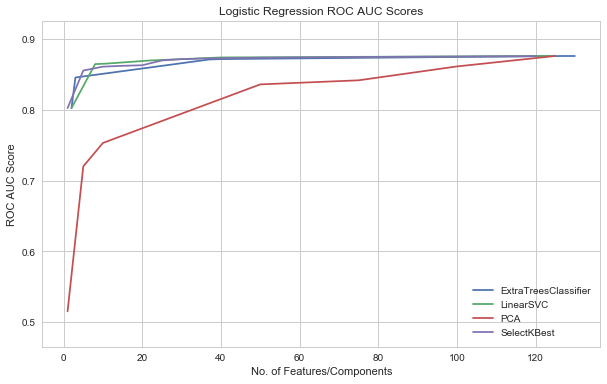

In [40]:
# convert our results into a dataframe
plt_results = pd.DataFrame(results_fs, columns=column_names)
fig,ax = plt.subplots(figsize=(10,6))

# loop through each classifier
for fs, data in plt_results.sort_values('features_selected').groupby('feat_selector'):

    # create the data
    x_data = data.features_selected
    y_data = data.roc_auc
    
    plt.plot(x_data, y_data, label=fs)

# limit the y axis
ax = plt.gca()
ax.set_ylim([min(plt_results.roc_auc)-0.05 , max(plt_results.roc_auc)+0.05])

# set titles
plt.title('Logistic Regression ROC AUC Scores')
plt.ylabel('ROC AUC Score')
plt.xlabel('No. of Features/Components')
plt.legend()

plt.savefig('../reports/figures/class_lr_select_features.png')

plt.show()

In [41]:
# View the detailed results
plt_results

,feat_selector,threshold,accuracy,rmse,roc_auc,features_selected
0,LinearSVC,1e-05,0.905429,0.307524,0.875977,125
1,LinearSVC,0.0001,0.905429,0.307524,0.875978,124
2,LinearSVC,0.01,0.905429,0.307524,0.873947,40
3,LinearSVC,0.02,0.905355,0.307644,0.869664,22
4,LinearSVC,0.03,0.905043,0.308150,0.865309,11
5,LinearSVC,0.04,0.905160,0.307962,0.864526,8
6,LinearSVC,mean,0.906015,0.306570,0.802449,2
7,ExtraTreesClassifier,1e-05,0.905434,0.307516,0.875986,130
8,ExtraTreesClassifier,0.0001,0.905434,0.307516,0.875984,127
9,ExtraTreesClassifier,0.01,0.905334,0.307679,0.871052,37


It appears that LinearSVC has performed the best.  We can acheive a roc auc score of ~87% using only 40 features (a thrid of the total number of features).  The ExtraTreesClassifer can achieve a similar score, however there appears to be a sharp drop off between threshold levels which could create a less robust model.

Although PCA doesn't select features (rather it selects components), we find that PCA would require over 120 components in order to match a score of 87%.  We are not reducing the complexity of our model in this case, and therefore we will not use PCA in this analysis. 

Finally, SelectKBest appears to have performed almost as good as LinearSVC.  The difference here is that SelectKBest achieves results in a fraction of time over LinearSVC.  As a result, we are going to choose SelectKBest as our feature selection, using only 35 features. 

## Logistic Regression - Feature Selection - Hyperparameter Tuning
Knowing SelectKBest performs well in feature selection, we now move to fine tuning our Logistic Regression classifier to see if we can acheive an even better score while using fewer features.  We were able to acheive an ROC AUC score of 87% using no feature selection or hyperparameter tuning.  Let's see if we can get near this score.

In [42]:
# we will do hyperparameter tuning on our logisitic regression
param_grid = [{'clf__C':[0.001, 0.01, 1, 10, 100, 500, 1000]}]

# create pipeline
pipe_fs = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(k=35)),
    ('clf', LogisticRegression())
])

# create our grid search
grid_search = GridSearchCV(pipe_fs, param_grid, n_jobs=-1, scoring=['accuracy', 'roc_auc'], refit='roc_auc', return_train_score=False)

# perform the fit
grid_search.fit(X_train, y_train)

# print out our best params
grid_search.best_params_

{'clf__C': 500}

With our parameters tuned, we bring it all together and perform one last test:

In [43]:
# create pipeline
pipe_lr_fs = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(k=35)),
    ('clf', LogisticRegression(C=500))
])

# fit the data
pipe_lr_fs.fit(X_train, y_train)

# predict X
y_pred_lr_fs = pipe_lr_fs.predict(X_train)
y_pred_test_lr_fs = pipe_lr_fs.predict(X_test)

# find the assigned scores for the y predictions (which is the second column in predicitions)
y_score_lr_fs = pipe_lr_fs.predict_proba(X_train)[:,1]
y_score_test_lr_fs = pipe_lr_fs.predict_proba(X_test)[:,1]

# find the scores
accuracy_score = pipe_lr_fs.score(X_train, y_train)
roc_auc = roc_auc_score(y_train, y_score_lr_fs)

accuracy_score_test = pipe_lr_fs.score(X_test, y_test)
roc_auc_test = roc_auc_score(y_test, y_score_test_lr_fs)

# print scores
print('Training Scores')
print('Accuracy: {}'.format(accuracy_score))
print('ROC AUC: {}'.format(roc_auc))
print()
print('Testing Scores')
print('Accuracy: {}'.format(accuracy_score_test))
print('ROC AUC: {}'.format(roc_auc_test))



Training Scores
Accuracy: 0.9136997660281294
ROC AUC: 0.902343919104331

Testing Scores
Accuracy: 0.9133314320119149
ROC AUC: 0.9012992383351174


In [44]:
# let's find the cross validation score
scores = cross_val_score(pipe_lr_fs, X, y, scoring='roc_auc', cv=10)
scores

array([ 0.98580905,  0.96562069,  0.95446419,  0.91968962,  0.90117016,
        0.88829307,  0.83582749,  0.8329485 ,  0.80148727,  0.72957784])

In [45]:
print("Accuracy: {0:.2f} (+/- {1:.5f})".format(scores.mean(), scores.std() * 2))

Accuracy: 0.88 (+/- 0.15375)


In [46]:
confusion_matrix(y_train, y_pred_lr_fs)

array([[152578,    302],
       [ 16038,  20421]])

In [47]:
print(classification_report(y_train, y_pred_lr_fs, target_names=['0', '1']))

             precision    recall  f1-score   support

          0       0.90      1.00      0.95    152880
          1       0.99      0.56      0.71     36459

avg / total       0.92      0.91      0.90    189339



Using cross validation, we see that we have achieved a roc auc score of 88% using only 35 features.  We successfully reduced the complexity of our model while maintaining a high roc auc score.  

We do notice that the recall score on the default class (1) is fairly bad (56%).  We have trouble correclty identifying default loans.  We are reporting 44% of default loans will not default.  This is an increase when compared to our model using all features; However, we still have room for improvement. 

Out of curiosity - what are the top 5 most important features?

In [48]:
from operator import itemgetter

sorted(list(zip(list(X.columns), list(pipe_lr_fs.named_steps['clf'].coef_[0]))), key=itemgetter(1), reverse=True)[:5]

[('delinq_2yrs', 931.47066295062564),
 ('mort_acc', 0.57405514278690672),
 ('term', 0.23765308586650682),
 ('int_rate', 0.23609001172482241),
 ('revol_bal', 0.22490877183248059)]

The most important features appear to be delinq_2yrs, mort_acc, term, int_rate, and revol_bal.  

Can we improve on this score using a different model?

## Random Forest Classifier
We've performed feature selection & hyperparamter tuning on our logistic regression classifier to achieve a roc auc score of 88%.  Is it possible to improve this score by using a different classifier?  

Let's have a look at the Random Forest Classifier to see.  We will first look at using only feature selection to find out how well we score.

In [49]:
from sklearn.tree import DecisionTreeClassifier

pipe_rf_fs = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(k=35)),
    ('rfc', RandomForestClassifier())
])

# fit the classifier
pipe_rf_fs.fit(X_train, y_train)

# predict 
y_pred_rf_fs = pipe_rf_fs.predict(X_train)
y_pred_rf_fs_test = pipe_rf_fs.predict(X_test)

# find the assigned scores for the y predictions (which is the second column in predicitions)
y_score_rf_fs = pipe_rf_fs.predict_proba(X_train)[:,1]
y_score_rf_fs_test = pipe_rf_fs.predict_proba(X_test)[:,1]

# find the scores
accuracy_score = pipe_rf_fs.score(X_train, y_train)
roc_auc = roc_auc_score(y_train, y_score_rf_fs)

# find the scores
accuracy_score_test = pipe_rf_fs.score(X_test, y_test)
roc_auc_test = roc_auc_score(y_test, y_score_rf_fs_test)

# print scores
print('Training')
print('Accuracy: {}'.format(accuracy_score))
print('ROC AUC: {}'.format(roc_auc))
print()
print('Testing')
print('Accuracy: {}'.format(accuracy_score_test))
print('ROC AUC: {}'.format(roc_auc_test))

Training
Accuracy: 0.9888982195955403
ROC AUC: 0.9999057683075298

Testing
Accuracy: 0.9220141331558767
ROC AUC: 0.8912982956527932


In [50]:
# let's find the cross validation score
scores = cross_val_score(pipe_rf_fs, X, y, scoring='roc_auc', cv=10)
scores

array([ 0.99502716,  0.96157513,  0.95792237,  0.88542054,  0.85840504,
        0.80822389,  0.69762514,  0.78219946,  0.76892563,  0.71405971])

In [51]:
print("Accuracy: {0:.2f} (+/- {1:.5f})".format(scores.mean(), scores.std() * 2))

Accuracy: 0.84 (+/- 0.20057)


The random forest classifier performs well, but it appears to have a wide variance when scoring.  The cross validation score is only 84%, slightly lower than our tuned Logistic Regression model. 

We do have a good ROC AUC score on our testing data, so let's try tuning the parameters to find out if we can achieve a more consistent score.

## Random Forest Classifier - Feature Selection & Hyperparameter Tuning
In order to tune our parameters, we will first look at each parameter individually, identifying a smaller range for each parameter which will then be used to tuning the final classifier. 

In [52]:
def plot_results(clf, param_name, param_values, plot_index):
    """
    Description
    -----------
        Allows us to test a parameter range and plot the results
        
    Parameters
    -----------
    clf: The classifier to be used for tuning
    
    param_name: name of the parameter to be tuned
    
    param_values: an array of values to be tested for the given parameter
    
    plot_index: identifies the index of the given subplot.  For this given setup, we 
        assume that we are using a 3 cols x 2 row setup

    
    """

    # create the grid search
    grid_search = GridSearchCV(clf, 
                               param_grid = {param_name:param_values},
                               return_train_score=True)
    
    # fit the estimator
    grid_search.fit(X_train, y_train)
    
    # create a dictionary to store the scores
    scores_dic = {}
    
    # loop through the parameter values tested
    for i, param_dic in enumerate(grid_search.cv_results_['params']):
        
        # Store the parameter tested with the related mean training score
        scores_dic[param_dic[param_name]] = grid_search.cv_results_['mean_train_score'][i]
    
    # create a dataframe from the parameter scores
    scores_df = pd.DataFrame.from_dict(scores_dic, orient='index')
    scores_df.reset_index(inplace=True)
    scores_df.columns = ['param', 'score']
    
    # plot the result
    plt.subplot(3, 2, plot_index)
    
    # if we are plotting max_features, we need to adjust the x values, as they are not
    # numeric.  Otherwise, we can just use the parameter values
    if param_name == 'max_features':
        plt.plot(np.arange(len(scores_df)), scores_df.score)
        plt.xticks(np.arange(len(scores_df)), scores_df.param.values)
    else:
        plt.plot(scores_df.param, scores_df.score)

    # add a title
    plt.title(param_name)


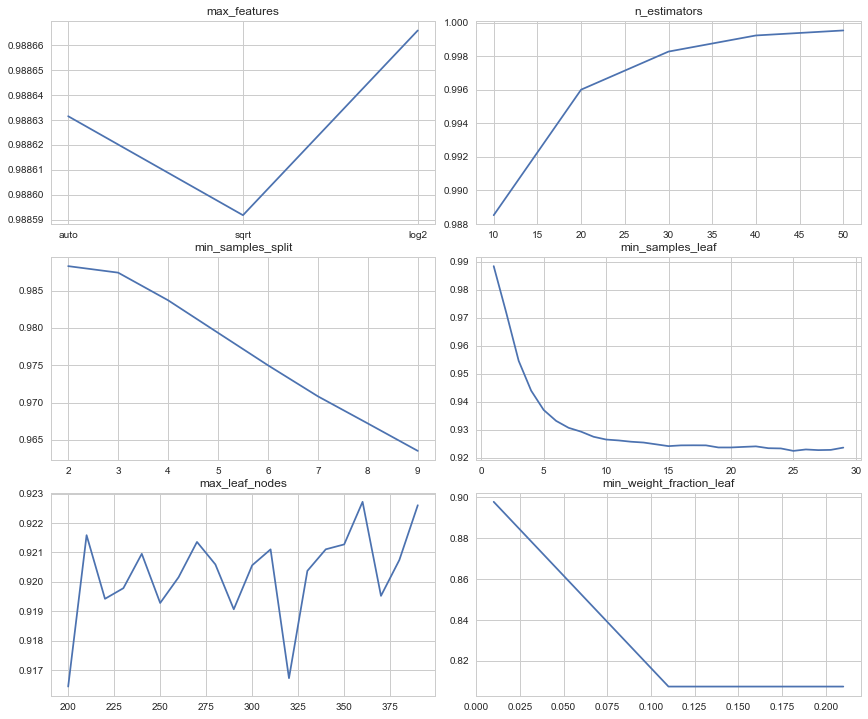

In [53]:
# Create the param_grid for testing
param_grid = {'max_features':['auto', 'sqrt', 'log2'],
              'n_estimators':[10, 20, 30, 40, 50],
              'min_samples_split': np.arange(2,10,1),
              'min_samples_leaf': np.arange(1,30,1),
              'max_leaf_nodes': np.arange(200,400,10),
              'min_weight_fraction_leaf': np.arange(0.01,0.3, 0.1)
             }

# create figure area
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
fig.tight_layout()

# loop through each parameter & value range, plotting the accuracy results
for i, (k, v) in enumerate(param_grid.items()):

    # call to display graph
    plot_results(RandomForestClassifier(n_jobs=-1), k, v, i+1)

plt.savefig('../reports/figures/class_rfc_params.png')

plt.show()

From the above plots, we now have a general idea of how well each parameter performs given a wide range of values.  

We can use this plot to narrow the range for each paramter and perform a final test using RandomizedSearchCV. 

In [54]:
# create the parameter grid
param_grid = {'rfc__n_estimators':[10, 20, 30, 40, 50],
              'rfc__min_samples_split': np.arange(2,5,1),
              'rfc__min_samples_leaf': np.arange(1,5,1),
              'rfc__max_leaf_nodes': np.arange(300,400,5),
              'rfc__min_weight_fraction_leaf': np.arange(0.01,0.1, 0.01)
             }

pipe_rf_fs = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(k=35)),
    ('rfc', RandomForestClassifier(max_features='log2', random_state=42))
])

random_search = RandomizedSearchCV(pipe_rf_fs, param_grid, scoring=['accuracy', 'roc_auc'],
                                  refit='roc_auc')

# fit the classifier
random_search.fit(X_train, y_train)

# find best params
random_search.best_params_

{'rfc__max_leaf_nodes': 315,
 'rfc__min_samples_leaf': 3,
 'rfc__min_samples_split': 3,
 'rfc__min_weight_fraction_leaf': 0.02,
 'rfc__n_estimators': 50}

The RandomizedSearchCV has provided us with the most optimal parameters.  We can use these in a classifer below to produce our final output.

In [55]:
# define our final pipeline
pipe_rf_fs = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(k=35)),
    ('rfc', RandomForestClassifier(random_state=42, max_leaf_nodes=335,
                                  min_samples_leaf=1, min_samples_split=3,
                                  min_weight_fraction_leaf=0.01, n_estimators=40))
])

# fit the classifier
pipe_rf_fs.fit(X_train, y_train)

# predict 
y_pred_rf_fs = pipe_rf_fs.predict(X_train)
y_pred_rf_fs_test = pipe_rf_fs.predict(X_test)

# find the assigned scores for the y predictions (which is the second column in predicitions)
y_score_rf_fs = pipe_rf_fs.predict_proba(X_train)[:,1]
y_score_rf_fs_test = pipe_rf_fs.predict_proba(X_test)[:,1]

# find the scores
accuracy_score = pipe_rf_fs.score(X_train, y_train)
roc_auc = roc_auc_score(y_train, y_score_rf_fs)

# find the scores
accuracy_score_test = pipe_rf_fs.score(X_test, y_test)
roc_auc_test = roc_auc_score(y_test, y_score_rf_fs_test)

# print scores
print('Training')
print('Accuracy: {}'.format(accuracy_score))
print('ROC AUC: {}'.format(roc_auc))
print()
print('Testing')
print('Accuracy: {}'.format(accuracy_score_test))
print('ROC AUC: {}'.format(roc_auc_test))

Training
Accuracy: 0.9173809938787043
ROC AUC: 0.9209046460459249

Testing
Accuracy: 0.9174826504420572
ROC AUC: 0.9171230791334479


In [56]:
# let's find the cross validation score
scores = cross_val_score(pipe_rf_fs, X, y, scoring='roc_auc', cv=10)
scores

array([ 0.99685146,  0.9794288 ,  0.97339026,  0.89855601,  0.89783958,
        0.84842263,  0.8235717 ,  0.8324134 ,  0.79837614,  0.75663773])

In [57]:
print("Accuracy: {0:.2f} (+/- {1:.5f})".format(scores.mean(), scores.std() * 2))

Accuracy: 0.88 (+/- 0.15652)


In [58]:
print(classification_report(y_train, y_pred_rf_fs, target_names=['0', '1']))

             precision    recall  f1-score   support

          0       0.91      1.00      0.95    152880
          1       1.00      0.57      0.73     36459

avg / total       0.93      0.92      0.91    189339



Using feature selection and hyperparameter tuning, we were able to improve our cross validated roc auc score to 88%.  We might assume that this metric is great, but our 'default' class recall score is 57%.  This means that we will incorrectly classify a default loan 43% of the time.

If we were to deploy this model to production, we would likely not last in the business world.  As we saw previously in logistic regression, this recall error this may be due to class imbalance.  Let's try balancing our data and attempting this random forest classification one more time. 

## Random Forest Classifier - SMOTE testing

We will balance our classes using the SMOTE technique prior to performing our classification.

In [59]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# balance our class
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_sample(X, y)

# display the sampled classes
print('Resampled dataset shape {}'.format(Counter(y_res)))

# split our data
X_train_rf_bal, X_test_rf_bal, y_train_rf_bal, y_test_rf_bal = train_test_split(X_res, y_res, test_size=0.25, random_state=42)

Resampled dataset shape Counter({0: 203835, 1: 203835})


With the classes balanced, we recreate our classifier using the same tuned parameters as above.

In [60]:
# define our final pipeline
pipe_rf_fs = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(k=35)),
    ('rfc', RandomForestClassifier(random_state=42, max_leaf_nodes=335,
                                  min_samples_leaf=1, min_samples_split=3,
                                  min_weight_fraction_leaf=0.01, n_estimators=40))
])

# fit the classifier
pipe_rf_fs.fit(X_train_rf_bal, y_train_rf_bal)

# predict 
y_pred_rf_fs_bal = pipe_rf_fs.predict(X_train_rf_bal)
y_pred_rf_fs_test_bal = pipe_rf_fs.predict(X_test_rf_bal)

# find the assigned scores for the y predictions (which is the second column in predicitions)
y_score_rf_fs_bal = pipe_rf_fs.predict_proba(X_train_rf_bal)[:,1]
y_score_rf_fs_test_bal = pipe_rf_fs.predict_proba(X_test_rf_bal)[:,1]

# find the scores
accuracy_score = pipe_rf_fs.score(X_train_rf_bal, y_train_rf_bal)
roc_auc = roc_auc_score(y_train_rf_bal, y_score_rf_fs_bal)

# find the scores
accuracy_score_test = pipe_rf_fs.score(X_test_rf_bal, y_test_rf_bal)
roc_auc_test = roc_auc_score(y_test_rf_bal, y_score_rf_fs_test_bal)

# print scores
print('Training')
print('Accuracy: {}'.format(accuracy_score))
print('ROC AUC: {}'.format(roc_auc))
print()
print('Testing')
print('Accuracy: {}'.format(accuracy_score_test))
print('ROC AUC: {}'.format(roc_auc_test))

Training
Accuracy: 0.9241934639838824
ROC AUC: 0.9764534311477622

Testing
Accuracy: 0.9236052512804411
ROC AUC: 0.9753993121062232


In [61]:
# let's find the cross validation score
scores = cross_val_score(pipe_rf_fs, X_res, y_res, scoring='roc_auc', cv=10)
scores

array([ 0.9738133 ,  0.90898089,  0.90628387,  0.99624774,  0.99123435,
        0.98920879,  0.97963776,  0.9831017 ,  0.98958559,  0.98700325])

In [62]:
print("Accuracy: {0:.2f} (+/- {1:.5f})".format(scores.mean(), scores.std() * 2))

Accuracy: 0.97 (+/- 0.06400)


In [63]:
print(classification_report(y_train_rf_bal, y_pred_rf_fs_bal, target_names=['0', '1']))

             precision    recall  f1-score   support

          0       0.87      1.00      0.93    152773
          1       1.00      0.85      0.92    152979

avg / total       0.93      0.92      0.92    305752



Using SMOTE, we've improved our scores across the board.  The cross validation produces a 97% roc auc score.  Our recall in the default class has also increased to 85%, meaning we are predicting default loans much better with the newly balanced data. 

Our recall score for the default class has also improved versus our logistic regression model.  Let's look at our top 5 features used for classifying:  

In [64]:
from operator import itemgetter

sorted(list(zip(list(X.columns), list(pipe_rf_fs.named_steps['rfc'].feature_importances_))), key=itemgetter(1), reverse=True)[:5]

[('open_acc', 0.35878723929712641),
 ('delinq_2yrs', 0.34613612723040121),
 ('term', 0.065140013398434463),
 ('int_rate', 0.034471941570914023),
 ('num_accts_ever_120_pd', 0.028428368177461048)]

Similarily to our Logistic Regression model, we find that the top 5 features used for the random forest model include:
delinq_2yrs, open_acc, int_rate, term, mort_acc.

Using this final classifier, we can compare the ROC curves of 4 different classifiers we expored in this notebook

1. Logistic Regression using only engineered features
2. Logistic Regression using all features
3. Logistic Regression using select features
4. Random Forest using select features

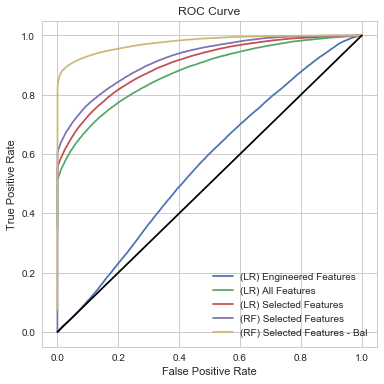

In [65]:
# create plot
plt.figure(figsize=(6,6))

# find roc curve for logisitic regression - Engineered Features
fpr_lr_fe, tpr_lr_fe, thresholds = roc_curve(y_train_bal, y_score_fe)

# find roc curve for logisitic regression - All Features
fpr_lr_af, tpr_lr_af, thresholds = roc_curve(y_train, y_score_lr_af)

# find roc curve for logisitic regression - Selected Features
fpr_lr_fs, tpr_lr_fs, thresholds = roc_curve(y_train, y_score_lr_fs)

# find roc curve for Random Forest - Selected Features
fpr_rf_fs, tpr_rf_fs, thresholds = roc_curve(y_train, y_score_rf_fs)

# find roc curve for Random Forest - Selected Features, balanced
fpr_rf_fs_bal, tpr_rf_fs_bal, thresholds = roc_curve(y_train_rf_bal, y_score_rf_fs_bal)

# plot ROC curve & 50% line
plt.plot(fpr_lr_fe, tpr_lr_fe, label='(LR) Engineered Features')
plt.plot(fpr_lr_af, tpr_lr_af, label='(LR) All Features')
plt.plot(fpr_lr_fs, tpr_lr_fs, label='(LR) Selected Features')
plt.plot(fpr_rf_fs, tpr_rf_fs, label='(RF) Selected Features')
plt.plot(fpr_rf_fs_bal, tpr_rf_fs_bal, label='(RF) Selected Features - Bal')

plt.plot([0,1], [0,1], color='black')

# set labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.savefig('../reports/figures/class_final_results.png')

plt.show()

## Conclusion

We've taken steps throughout this notebook to improve performance of our model to predict Lending Club defaults.

We've seen how using too few features can causes poor performance in a model.  We've also seen how model tuning can be used to reduce complexity and improve model performance.

The roc auc score has been used as the benchmark score to evaluate model performance throughout this notebook.  Ultimately, our Random Forest classifier has out performed our Logistic Regression model - as displayed in the ROC curve above. 

This is likley due to the fact that Random Forests produces non-linear decision boundaries, whereas Logistic Regression produces a single linear decision boundary.  We also must note that balancing our class greatly improved our classification success, improving our Random Forest model to 97% during our last cross validation test. 

When investigating feature importances, we find the following information is most important when predicting defaults:
* **delinq_2yrs**: The number of of 30+ days past-due incidences of delinquency in the borrower's credit in the past 2 years.
* **open_acc**: The number of open credit lines in the borrower's credit file
* **int_rate**: Interest rate on the loan
* **term**: The number of payments on the loan (in months)
* **mort_acc**: Number of mortgage accounts

